In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ammonia1
import system_aqua1
import numpy as np
import matplotlib.pyplot as plt

In [3]:
T_heat_reject = 305.
U = 100
xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
bdry = system_aqua1.makeBoundary(xB)
bdry

stream             T_inlet    mdot     cp
---------------  ---------  ------  -----
heat                   400    1     4.179
absorberReject         305    3     4.179
condReject             305    5     4.179
cold                   285    4     4.179
rectifierReject        305    0.15  4.179

In [4]:
xC = np.array([0.51284472, 277.97717012, 312.16427764, 313.6952877,
               310.24856734, 374.14020482])
ch = system_aqua1.makeChiller(xC)
ch

                                 T         P         x          h         s          u           v            Qu
-------------------------  -------  --------  --------  ---------  --------  ---------  ----------  ------------
rich_abs_outlet            310.249   4.87444  0.512028   -73.1846  0.395262   -73.7844  0.00123041   0
rich_pump_outlet           310.413  15.1396   0.512028   -71.6061  0.396279   -73.4682  0.00122993  -0.001
rich_shx_outlet            345.852  15.1396   0.512028    89.9885  0.889071    88.0334  0.00129135  -0.001
rich_gen_sat_liquid        351.91   15.1396   0.512028   118.322   0.970284   116.346   0.00130467   0
weak_gen_outlet            374.14   15.1396   0.39475    225.935   1.26082    224.014   0.00126878   0
weak_shx_outlet            329.938  15.1396   0.39475     25.493   0.691038    23.6904  0.00119066  -0.001
weak_exp_outlet            330.108   4.87444  0.39475     25.493   0.694743    24.911   0.00119402   7.84229e-06
gen_vapor_outlet           351.

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


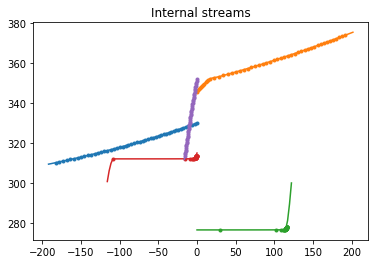

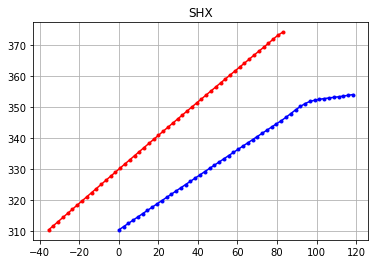

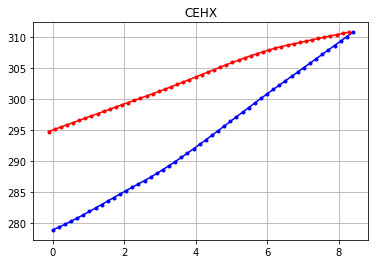

In [5]:
ch.display()
plt.show()

In [6]:
sys = system_aqua1.System(boundary=bdry, chiller=ch)
sys

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name      deltaT    epsilon        UA         Q
------  --------  ---------  --------  --------
gen      5.60995   0.891216  14.9063   192.048
rect     8.66502   0.799757   1.04183   15.7864
abs      5.25365   0.735388  27.2915   182.886
cond     2.20854   0.967334  27.3363   110.508
evap     1.45034   0.982521  29.4333   116.323
totalUA = 100.00919302098899

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
widgets.__version__

'6.0.0'

In [4]:
def square(num=1):
        print("{} squared is {}".format(num, num*num))
interact(square, num=5)

5 squared is 25


<function __main__.square>

In [5]:
from ipywidgets import IntSlider
from IPython.display import display
slider = IntSlider(min=1, max=10)
display(slider)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [6]:
IntSlider(5)

Widget Javascript not detected.  It may not be installed or enabled properly.
